# Saving logits of original and adversarially attacked inputs

The "hack" below allows absolute path imports as if the notebook was a py-file run with `python -m abs.path.to.file.filename`

In [1]:
import sys
root_dir = !cd .. &&pwd
root_dir = root_dir[0] + "/"
sys.path.insert(0, root_dir)

In [2]:
print(root_dir)

/Users/gunder/Desktop/bachelor_project/


### Imports

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from models.classifier32 import classifier32

from our_modules.tin_tools import get_avg_osr_auroc_across_splits
from our_modules.tin_tools import transform_range as tin_clip_range
from our_modules.tin_tools import save_grad_norms_across_splits
from our_modules.tin_tools import save_informed_attack

from our_modules.adv_tools import fp_osr_fgsm, fn_osr_fgsm, fp_osr_fgsm_sum_exp, fn_osr_fgsm_log_msp, fn_osr_fgsm_sum_exp
from our_modules.adv_tools import log_msp_loss



### Setting the Device

In [4]:
if sys.platform == 'darwin':
    device = torch.device("mps")
else:
    gpu = torch.cuda.is_available()
    device = torch.device("cuda:0" if gpu else "cpu")

print("device:", device)

device: mps


## tiny-imagenet

In [5]:
path_to_pretrained_weights_folder = root_dir + "pretrained_weights/"
tin_val_root_dir = root_dir + "datasets/tiny-imagenet-200/val/images/"
tin_logits_dir = root_dir + "logits/tinyimagenet/"
tin_grad_norms_dir = root_dir + 'grad_norms/tinyimagenet/'

### Saving plain logits

In [6]:
#get_avg_osr_auroc_across_splits(path_to_pretrained_weights_folder, tin_val_root_dir, device, logdir=tin_logits_dir + "plain/")

### Savining Advesarial Attacks Logits

#### FGSM for different epsilon

##### FN

In [6]:
def fgsm_eps_experiment(eps_list, fgsm, logdir, number_of_splits=5, **fgsm_kwargs):
    for eps in eps_list:
        attack = (lambda x, y, model: fgsm(model, x, eps=eps, clip_range=tin_clip_range, **fgsm_kwargs))
        get_avg_osr_auroc_across_splits(path_to_pretrained_weights_folder, tin_val_root_dir, device, logdir + f"eps_{eps:.3}/", adv_attack=attack, number_of_splits=number_of_splits)


In [16]:
eps = np.linspace(1.20,2, 5)

In [17]:
eps

array([1.2, 1.4, 1.6, 1.8, 2. ])

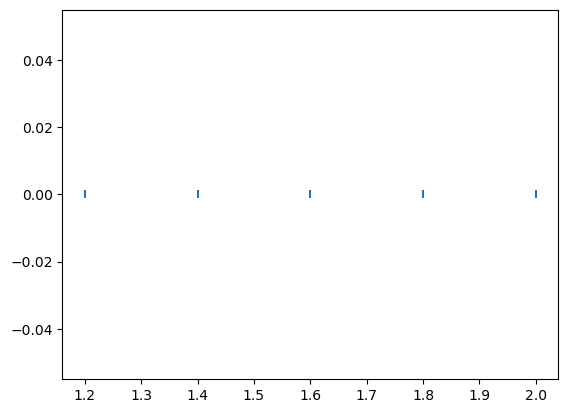

In [18]:
fig, ax = plt.subplots(1,1)
ax.scatter(eps, np.zeros_like(eps), marker ='|')
plt.show()

In [11]:
#fgsm_eps_experiment(eps, fn_osr_fgsm, tin_logits_dir + "fn/fgsm/", 1)

#### FP

2-norm

In [12]:
#fgsm_eps_experiment(eps_list=eps, fgsm=fp_osr_fgsm, logdir=tin_logits_dir + "fp/fgsm/two_norm/", number_of_splits=1, norm_ord=None)
#fgsm_eps_experiment(eps_list=eps, fgsm=fp_osr_fgsm, logdir=tin_logits_dir + "fp/fgsm/inf_norm/", number_of_splits=1, norm_ord=torch.inf)
# fgsm_eps_experiment(eps_list=eps, fgsm=fp_osr_fgsm_sum_exp, logdir=tin_logits_dir + "fp/fgsm/sum_exp/", number_of_splits=1)
fgsm_eps_experiment(eps_list=eps, fgsm=fn_osr_fgsm, logdir=tin_logits_dir + "fn/fgsm/inf_norm/", number_of_splits=1, norm_ord=torch.inf)
fgsm_eps_experiment(eps_list=eps, fgsm=fn_osr_fgsm_log_msp, logdir=tin_logits_dir + "fn/fgsm/log_msp/", number_of_splits=1)
fgsm_eps_experiment(eps_list=eps, fgsm=fn_osr_fgsm_sum_exp, logdir=tin_logits_dir + "fn/fgsm/sum_exp/", number_of_splits=1)

### Saving Grad Norms 
Testing Odin paper

In [14]:
#save_grad_norms_across_splits(path_to_pretrained_weights_folder, tin_val_root_dir, tin_grad_norms_dir + 'log_msp/', log_msp_loss, device, number_of_splits=5)

### Informed Attack

In [15]:
#save_informed_attack(tin_logits_dir + 'informed/fgsm/test/', tin_logits_dir + 'fn/fgsm/inf_norm/eps_0.139/', tin_logits_dir + 'fp/fgsm/two_norm/eps_0.592/', 0)

[tensor([[ 0.0392,  0.0030, -0.0092,  1.3336,  0.0235,  0.0023,  0.0027, -0.0234,
          0.0297,  0.0132,  0.0240,  0.0081, -0.0094, -0.0118,  0.0130,  0.0678,
         -0.0300,  0.0376, -0.0152,  0.0406]]), tensor([[ 0.0459,  0.0873,  0.0332,  0.0476,  0.0198,  0.0705,  0.0143,  0.0780,
          0.0166,  0.0426,  0.0195,  0.2211, -0.0348, -0.0245,  0.0639,  0.8274,
          0.0157,  0.0370,  0.0282,  0.0176]]), tensor([[-0.0175,  0.0111,  0.0971,  0.0677,  1.0324, -0.1415, -0.1002,  0.2506,
         -0.0527,  0.0567,  0.0814,  0.1242,  0.0390,  0.0372,  0.0643,  0.0349,
          0.0347, -0.0318,  0.0228,  0.0452]]), tensor([[ 0.0497, -0.0483, -0.1989,  1.3230, -0.0607, -0.0581, -0.0851, -0.0329,
         -0.0604, -0.0030, -0.0679,  0.3459, -0.0433,  0.1751, -0.0475,  0.0577,
         -0.0536, -0.1222, -0.0370, -0.0240]]), tensor([[-0.0164, -0.0949, -0.0596, -0.0367, -0.0152, -0.0525, -0.0454, -0.0180,
         -0.0527,  0.0053, -0.0245, -0.0612, -0.0202, -0.0448,  1.8873, -0.050